## Overview

In [3]:
from fastai.conv_learner import *
from fastai.dataset import *

import pandas as pd
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split

### Data + Pretrained code

In [4]:
PATH = './'
TRAIN = '../input/airbus-ship-detection/train_v2/'
TEST = '../input/airbus-ship-detection/test_v2/'
SEGMENTATION = '../input/airbus-ship-detection/train_ship_segmentations_v2.csv'
# PRETRAINED = '../input/fine-tuning-resnet34-on-ship-detection/models/Resnet34_lable_256_1.h5'
exclude_list = ['6384c3e78.jpg','13703f040.jpg', '14715c06d.jpg',  '33e0ff2d5.jpg',
                '4d4e09f2a.jpg', '877691df8.jpg', '8b909bb20.jpg', 'a8d99130e.jpg', 
                'ad55c3143.jpg', 'c8260c541.jpg', 'd6c7f17c7.jpg', 'dc3e7c901.jpg',
                'e44dffe88.jpg', 'ef87bad36.jpg', 'f083256d8.jpg'] #corrupted images

In [5]:
tr_arr = np.array(pd.read_csv('../input/traintestval-airbus/train_df.csv')['0'].reset_index(drop=True))
val_arr = np.array(pd.read_csv('../input/traintestval-airbus/val_df.csv')['0'].reset_index(drop=True))
test_arr = np.array(pd.read_csv('../input/traintestval-airbus/test_df.csv')['0'].reset_index(drop=True))

In [6]:
nw = 2   #number of workers for data loader
arch = resnet34 #specify target architecture

In [7]:
for el in exclude_list:
    if(el in tr_arr): tr_arr.remove(el)
    if(el in val_arr): val_arr.remove(el)
    if(el in test_arr): test_arr.remove(el)
segmentation_df = pd.read_csv(os.path.join(PATH, SEGMENTATION)).set_index('ImageId')

In [8]:
tr_n = tr_arr
val_n = val_arr
test_n = test_arr

In [9]:
def cut_empty(names):
    return [name for name in names 
            if(type(segmentation_df.loc[name]['EncodedPixels']) != float)]

tr_n = cut_empty(tr_n)
val_n = cut_empty(val_n)

In [10]:
total_n = tr_n + val_n

In [11]:
def get_mask(img_id, df):
    shape = (768,768)
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    masks = df.loc[img_id]['EncodedPixels']
    if(type(masks) == float): return img.reshape(shape)
    if(type(masks) == str): masks = [masks]
    for mask in masks:
        s = mask.split()
        for i in range(len(s)//2):
            start = int(s[2*i]) - 1
            length = int(s[2*i+1])
            img[start:start+length] = 1
    return img.reshape(shape).T

def Show_images(x,yp,yt):
    columns = 3
    rows = min(bs,8)
    fig=plt.figure(figsize=(columns*4, rows*4))
    for i in range(rows):
        fig.add_subplot(rows, columns, 3*i+1)
        plt.axis('off')
        plt.imshow(x[i])
        fig.add_subplot(rows, columns, 3*i+2)
        plt.axis('off')
        plt.imshow(yp[i])
        fig.add_subplot(rows, columns, 3*i+3)
        plt.axis('off')
        plt.imshow(yt[i])
    plt.show()

In [12]:
class pdFilesDataset(FilesDataset):
    def __init__(self, fnames, path, transform):
        self.segmentation_df = pd.read_csv(SEGMENTATION).set_index('ImageId')
        super().__init__(fnames, transform, path)
    
    def get_x(self, i):
        img = open_image(os.path.join(self.path, self.fnames[i]))
        if self.sz == 768: return img 
        else: return cv2.resize(img, (self.sz, self.sz))
    
    def get_y(self, i):
        mask = np.zeros((768,768), dtype=np.uint8) if (self.path == TEST) \
            else get_mask(self.fnames[i], self.segmentation_df)
        img = Image.fromarray(mask).resize((self.sz, self.sz)).convert('RGB')
        return np.array(img).astype(np.float32)
    
    def get_c(self): return 0
     

def get_data(sz,bs):
    #data augmentation
    aug_tfms = [RandomRotate(45,p=0.75, tfm_y=TfmType.CLASS)]
    tfms = tfms_from_model(arch, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS,aug_tfms=aug_tfms)
    tr_names = tr_n if (len(tr_n)%bs == 0) else tr_n[:-(len(tr_n)%bs)] #cut incomplete batch
    ds = ImageData.get_ds(pdFilesDataset, (tr_names,TRAIN), (val_n,TRAIN), tfms, test=(test_n,TRAIN))
    md = ImageData(PATH, ds, bs, num_workers=nw, classes=None)
    #md.is_multi = False
    return md

def get_data_no_aug(sz,bs):
    #data augmentation
    tfms = tfms_from_model(arch, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS)
    tr_names = tr_n if (len(tr_n)%bs == 0) else tr_n[:-(len(tr_n)%bs)] #cut incomplete batch
    ds = ImageData.get_ds(pdFilesDataset, (tr_names,TRAIN), (val_n,TRAIN), tfms, test=(test_n,TRAIN))
    md = ImageData(PATH, ds, bs, num_workers=nw, classes=None)
    #md.is_multi = False
    return md

### Model

In [13]:
cut,lr_cut = model_meta[arch]

In [14]:
def get_base():                   #load ResNet34 model
    layers = cut_model(arch(True), cut)
    return nn.Sequential(*layers)

In [15]:
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p))

class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()
    
class Unet34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(512,256,256)
        self.up2 = UnetBlock(256,128,256)
        self.up3 = UnetBlock(256,64,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = nn.ConvTranspose2d(256, 1, 2, stride=2)
        
    def forward(self,x):
        x = F.relu(self.rn(x))
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x)
        return x[:,0]
    
    def close(self):
        for sf in self.sfs: sf.remove()
            
class UnetModel():
    def __init__(self,model,name='Unet'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model)[1:]]

### Loss function

In [16]:
def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0

    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))

In [17]:
class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.mean()

In [18]:
class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)
        
    def forward(self, input, target):
        loss = self.alpha*self.focal(input, target) - torch.log(dice_loss(input, target))
        return loss.mean()

In [19]:
def dice(pred, targs):
    pred = (pred>0).float()
    return 2.0 * (pred*targs).sum() / ((pred+targs).sum() + 1.0)

def IoU(pred, targs):
    pred = (pred>0).float()
    intersection = (pred*targs).sum()
    return intersection / ((pred+targs).sum() - intersection + 1.0)

### Train Augmented Learner

In [20]:
sz = 768 #image size
bs = 8  #batch size

md = get_data(sz,bs)
no_aug_md = get_data_no_aug(sz,bs)

In [21]:
m_base = get_base()
state = torch.load('../input/traintestval-airbus/Unet34_768_aug_0.h5')
m_base.load_state_dict(state, strict=False)

m = to_gpu(Unet34(m_base))
models = UnetModel(m)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:06<00:00, 13283923.95it/s]


In [22]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit = MixedLoss(10.0, 2.0)
learn.metrics=[accuracy_thresh(0.5),dice,IoU]
wd=1e-7
lr = 1e-2

In [23]:
learn.freeze_to(1)
learn.fit(lr,1,wds=wd,cycle_len=1,use_clr=(5,8))

A Jupyter Widget

epoch      trn_loss   val_loss   <lambda>   dice       IoU        
    0      0.319124   0.26009    0.998578   0.830238   0.717955  



[0.26009032, 0.9985778736122904, 0.830237970700366, 0.7179548203151194]

In [25]:
learn.save('Unet34_768_aug_0')

 The lr of the head part is still 1e-3, while the middle layers of the model are trained with 1e-4 lr, and the base is trained with even smaller lr, 1e-5, since low level detectors do not vary much from one image data set to another.

In [26]:
# Unfreeze and train with differential learning rate
lrs = np.array([lr/100,lr/10,lr])
learn.unfreeze() #unfreeze the encoder
learn.bn_freeze(True)

learn.fit(lrs,2,wds=wd,cycle_len=1,use_clr=(20,8))

A Jupyter Widget

epoch      trn_loss   val_loss   <lambda>   dice       IoU        
    0      0.238409   0.231056   0.998712   0.84426    0.738249  
    1      0.243468   0.218686   0.99877    0.852026   0.749086  



[0.21868648, 0.9987702248905199, 0.8520263277154552, 0.7490861672735726]

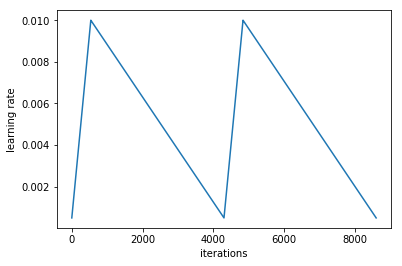

In [27]:
learn.sched.plot_lr()

In [28]:
learn.save('Unet34_768_aug_1')

## Training non-augmented learner

In [29]:
sz = 768 #image size
bs = 8  #batch size

no_aug_md = get_data_no_aug(sz,bs)

m_base = get_base()
state_na = torch.load('../input/traintestval-airbus/Unet34_768_no_aug_0.h5')
m_base.load_state_dict(state_na, strict=False)
m = to_gpu(Unet34(m_base))

learn_na = ConvLearner(no_aug_md, models)
learn_na.opt_fn=optim.Adam
learn_na.crit = MixedLoss(10.0, 2.0)
learn_na.metrics=[accuracy_thresh(0.5),dice,IoU]
wd=1e-7
lr = 1e-2

In [30]:
# Deprecated
learn_na.freeze_to(1)
learn_na.fit(lr,1,wds=wd,cycle_len=1,use_clr=(5,8))
learn_na.save('Unet34_768_no_aug_0')

A Jupyter Widget

epoch      trn_loss   val_loss   <lambda>   dice       IoU        
    0      0.224201   0.249682   0.998593   0.835697   0.726189  



In [31]:
# Unfreeze and train with differential learning rate
lrs = np.array([lr/100,lr/10,lr])
learn_na.unfreeze() #unfreeze the encoder
learn_na.bn_freeze(True)

learn_na.fit(lrs,2,wds=wd,cycle_len=1,use_clr=(20,8))

learn_na.save('Unet34_768_no_aug_1')

A Jupyter Widget

epoch      trn_loss   val_loss   <lambda>   dice       IoU        
    0      0.186713   0.197805   0.99888    0.865207   0.767906  
    1      0.186849   0.1859     0.998934   0.872038   0.777922  



### Visualization

In [3]:
def Show_images(x,yp,yt):
    columns = 3
    rows = min(bs,8)
    fig=plt.figure(figsize=(columns*4, rows*4))
    for i in range(rows):
        fig.add_subplot(rows, columns, 3*i+1)
        plt.axis('off')
        plt.imshow(x[i])
        fig.add_subplot(rows, columns, 3*i+2)
        plt.axis('off')
        plt.imshow(yp[i])
        fig.add_subplot(rows, columns, 3*i+3)
        plt.axis('off')
        plt.imshow(yt[i])
    plt.show()
    
    
def Show_images(x,y,x1,y1):
    columns = 4
    rows = min(bs,8)
    fig=plt.figure(figsize=(columns*4, rows*4))
    for i in range(rows):
        fig.add_subplot(rows, columns, 4*i+1)
        plt.axis('off')
        plt.imshow(x[i])
        fig.add_subplot(rows, columns, 4*i+2)
        plt.axis('off')
        plt.imshow(y[i])
        fig.add_subplot(rows, columns, 4*i+3)
        plt.axis('off')
        plt.imshow(x1[i])
        fig.add_subplot(rows, columns, 4*i+4)
        plt.axis('off')
        plt.imshow(y1[i])
    plt.show()

In [4]:
sz = 768 #image size
bs = 8  #batch size

md = get_data(sz,bs)
no_aug_md = get_data_no_aug(sz,bs)

NameError: name 'get_data' is not defined

In [5]:
x,y= md[0].trn_ds[2]
ox,oy = md[1].trn_ds[2]

NameError: name 'md' is not defined

In [6]:
plt.imshow(md[0].trn_ds.denorm(x)[0])

NameError: name 'plt' is not defined

In [ ]:
plt.imshow(y)

In [7]:
plt.imshow(md[1].trn_ds.denorm(ox)[0])

NameError: name 'plt' is not defined

In [ ]:
plt.imshow(oy)